In [7]:
%matplotlib inline

import os
import cmaps
import salem
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from myfunc import timer
from myfunc import DirMan
import config
import matplotlib.font_manager as fm
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from matplotlib import ticker
import math

# configuration
# resolution = "0p1"
resolution = "500"
region = [-180,180,-60,90]
data_path = f'/tera04/zhwei/xionghui/bedrock/run/{resolution}/'
post_data_path = '/tera04/zhwei/xionghui/bedrock/'
shp_path = '/tera04/zhwei/xionghui/bedrock/Shp/'
fig_path = f'/home/xuxh22/stu01/Bedrock/fig/{resolution}/'
path = '/home/xuxh22/stu01/Bedrock/'
if resolution == "0p1":
    size = 0.1
elif resolution == "500":
    size = 0.0005

print('python draw_g2_scatter.py')
print(data_path)
dir_man = DirMan(data_path)
dir_man.enter()
os.makedirs(f'{fig_path}/global_map_2', exist_ok=True)

shp = gpd.GeoDataFrame.from_file(shp_path+'World_CN/ne_10m_admin_0_countries_chn.shp')

pd.set_option('display.max_columns', None)
# font = {'family': 'Times New Roman'}
font = {'family': 'Arial'}
matplotlib.rc('font', **font)

params = {'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

font_properties = fm.FontProperties(weight='bold')

casename1 = 'bedrock_1'
path1 = f'{data_path}/cases/{casename1}/'
casename2 = 'bedrock_2'
path2 = f'{data_path}/cases/{casename2}/'
casename3 = 'bedrock_3'
path3 = f'{data_path}/cases/{casename3}/'

python draw_g2_scatter.py
/tera04/zhwei/xionghui/bedrock/run/500/
Entered /tera04/zhwei/xionghui/bedrock/run/500/


In [9]:
def read_data(df1,var):
    paths = [path1, path2, path3]
    num = len(paths)
    comb_num = math.comb(num, 2)
    all_num = num + comb_num
    comb_paths = list(combinations(paths, 2))

    nmean = np.zeros(all_num)
    nmedian = np.zeros(all_num)
    nstd = np.zeros(all_num)
    nmax = np.zeros(all_num)

    for i,path in enumerate(paths):
        name = f'{path}{var}'
        nmean[i]=df1[name].mean()
        nmedian[i]=df1[name].median()
        nstd[i]=df1[name].std()
        nmax[i]=df1[name].max()
    
    new_name1 = ['Exp1','Exp2','Exp3']
    new_name2 = ['Exp1-Exp2','Exp1-Exp3','Exp2-Exp3']
    for j,two_path in enumerate(comb_paths):
        name1 = f'{two_path[0]}{var}'
        name2 = f'{two_path[1]}{var}'
        df1[new_name2[j]] = df1[name1] - df1[name2]
        nmean[j+num]=df1[new_name2[j]].mean()
        nmedian[j+num]=df1[new_name2[j]].median()
        nstd[j+num]=df1[new_name2[j]].std()
        nmax[j+num]=df1[new_name2[j]].max()

    var_prefix = var.split('_')[0]

    # Create a DataFrame with the statistics
    stats_df = pd.DataFrame({
        'mean': nmean,
        'median': nmedian,
        'std': nstd,
        'max': nmax,
    }, index=new_name1 + new_name2)

    stats_df.to_csv(f'{data_path}csv/Global_cases_{var_prefix}_stat.csv', index=True, index_label='Index', float_format='%.6f', encoding='utf-8-sig')

    return stats_df

In [13]:
def draw_exp(stats_df,diff=False):
    colours = ['#4f83ae','#f0734d', '#dbb355','#75ae6c', '#b16e45','#8f2887']

    if diff:
        df = stats_df.iloc[3:,:].copy()
        colours=colours[3:]
    else:
        df = stats_df.iloc[:3,:].copy()
        colours=colours[:3]

    # 定义类别列（用于颜色区分）
    df['category'] = pd.Categorical(df.index)


    # 定义要绘制的列
    cols = ['mean', 'median', 'std', 'max']
    x = [i for i, _ in enumerate(cols)]

    # 定义颜色（为 3 行数据分配 3 种颜色）
    
    colours = {df['category'].cat.categories[i]: colours[i] for i, _ in enumerate(df['category'].cat.categories)}

    def get_ticks(vmin, vmax):
        diff = vmax - vmin
        small_value = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
        large_value = sorted(set([int(i * 10**e) if i * 10**e > 10 else i * 10**e for e in range(4) for i in [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10] if i * 10**e <= 10000]))
        ALLOWED_TICKS = small_value + large_value
        TARGET_NUM_TICKS = 5
        ideal_tick = diff / TARGET_NUM_TICKS
        for tick in ALLOWED_TICKS:
            if tick >= ideal_tick:
                return tick
        return ALLOWED_TICKS[-1]

    # 设置 y 轴刻度和标签
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        num_range = (max_val-min_val)/val_range
        tick_labels = np.linspace(int(min_val),int(max_val),int(num_range)+1).astype(int)
        ticks = np.linspace(0,1,int(num_range)+1)
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels, size=20)

    # 数据标准化
    min_max_range = {}
    for col in cols:
        min_val, max_val = df[col].min(), df[col].max()
        # print(min_val, max_val)
        val_range = int(get_ticks(min_val, max_val))
        min_val = int(min_val//val_range*val_range)
        max_val = int((max_val//val_range+1)*val_range)
        # print(min_val, max_val, val_range)
        min_max_range[col] = [min_val, max_val, val_range]
        df[col] = np.true_divide(df[col] - min_val, max_val-min_val)

    # 创建子图（5列需要4个子图）
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(12, 6))

    # 绘制每行数据
    for i, ax in enumerate(axes):
        for idx in df.index:
            category = df.loc[idx, 'category']
            ax.plot(x, df.loc[idx, cols], colours[category], lw=3)
            # print(df.loc[idx, cols])
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim(0,1)
        # ax.set_xlabel(cols[i], fontsize=14, color='black',weight='bold', labelpad=10)
        ax.xaxis.set_ticks_position('top')
        ax.spines['top'].set_linewidth(0)
        ax.spines['bottom'].set_linewidth(0)

    # 为每个子图设置刻度和 x 轴标签
    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=5)
        # ax.set_xticklabels([cols[dim]], size=32, weight='bold')
        ax.set_xticklabels([])
        ax.tick_params(axis='x', pad=20)

    # 处理最后一个子图的右侧 y 轴
    ax = plt.twinx(axes[-1])

    dim = len(axes)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    ax.spines['left'].set_position(('data', 3)) 
    ax.set_ylim(0,1)

    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    # ax.set_xticklabels([cols[-2], cols[-1]], size=32, weight='bold')

    ax.xaxis.set_ticks_position('top')
    set_ticks_for_axis(dim, ax, ticks=5)

    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(0)
    ax.tick_params(axis='x', pad=20)


    # 移除子图间距
    plt.subplots_adjust(wspace=0)

    # # 添加图例
    # plt.legend(
    #     [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df['category'].cat.categories],
    #     df['category'].cat.categories,
    #     bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    plt.show()

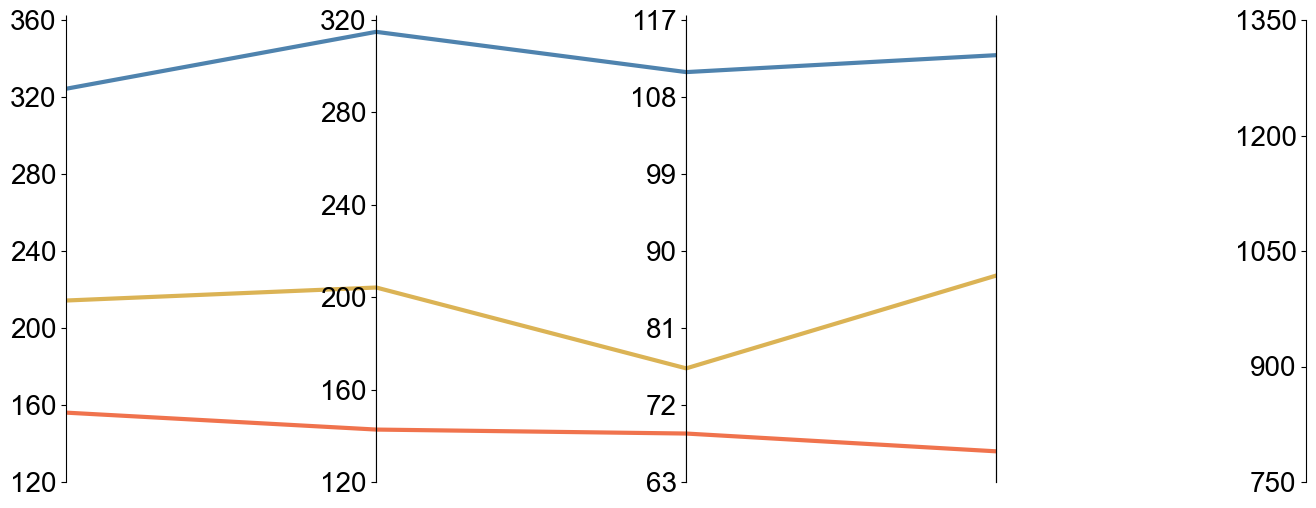

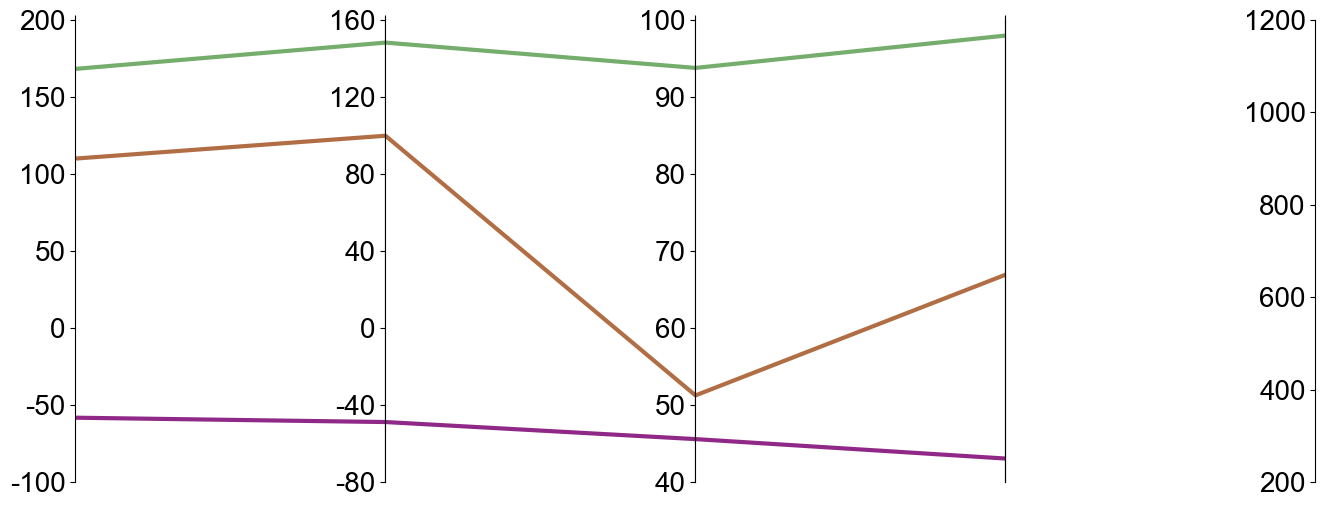

,mean,median,std,max
Exp1,324.294379,314.873660,110.911228,1304.32930
Exp2,156.029635,142.698230,68.664542,789.82890
Exp3,214.276765,204.193920,76.282574,1018.09960
Exp1-Exp2,168.264744,148.252880,93.777062,1166.29215
Exp1-Exp3,110.017614,99.878140,51.246408,648.67854
Exp2-Exp3,-58.247130,-48.851447,45.570725,250.77735


In [ ]:
df = pd.read_csv(f'{data_path}csv/Global_cases_sr.csv')
df1 = df.copy()
stats_df = read_data(df1,'Sr_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

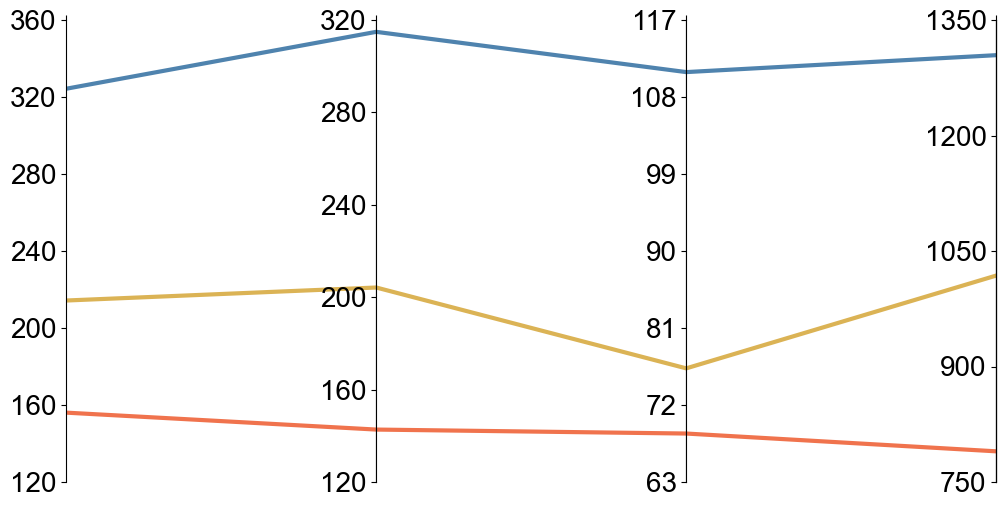

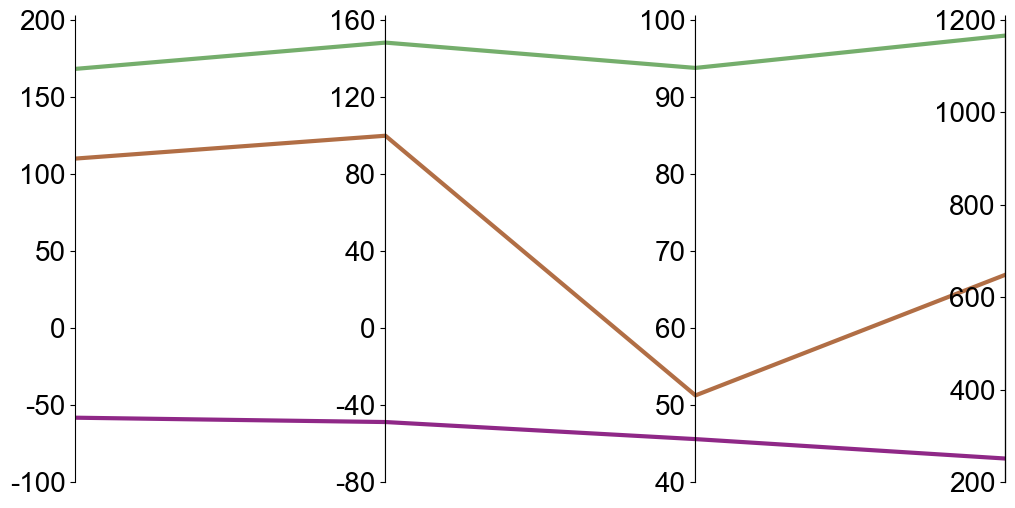

,mean,median,std,max
Exp1,324.294379,314.873660,110.911228,1304.32930
Exp2,156.029635,142.698230,68.664542,789.82890
Exp3,214.276765,204.193920,76.282574,1018.09960
Exp1-Exp2,168.264744,148.252880,93.777062,1166.29215
Exp1-Exp3,110.017614,99.878140,51.246408,648.67854
Exp2-Exp3,-58.247130,-48.851447,45.570725,250.77735


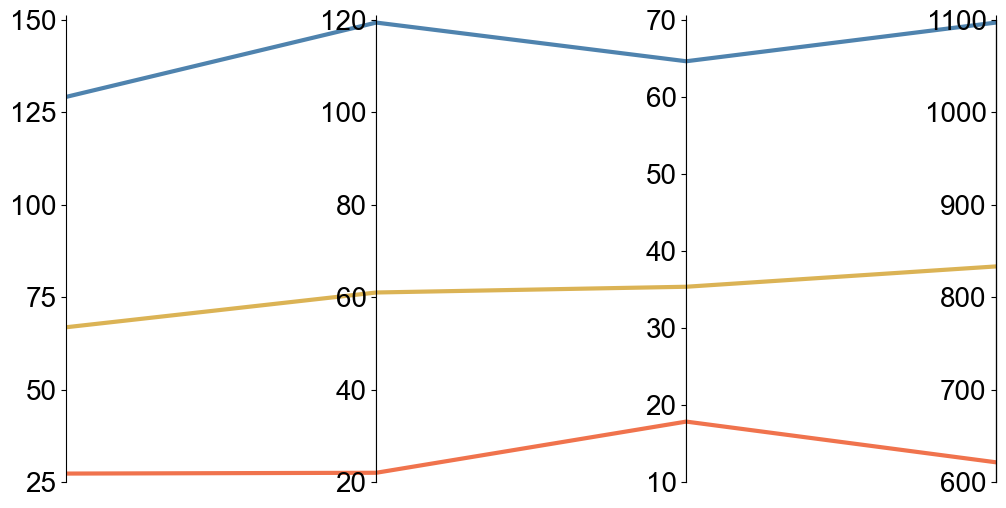

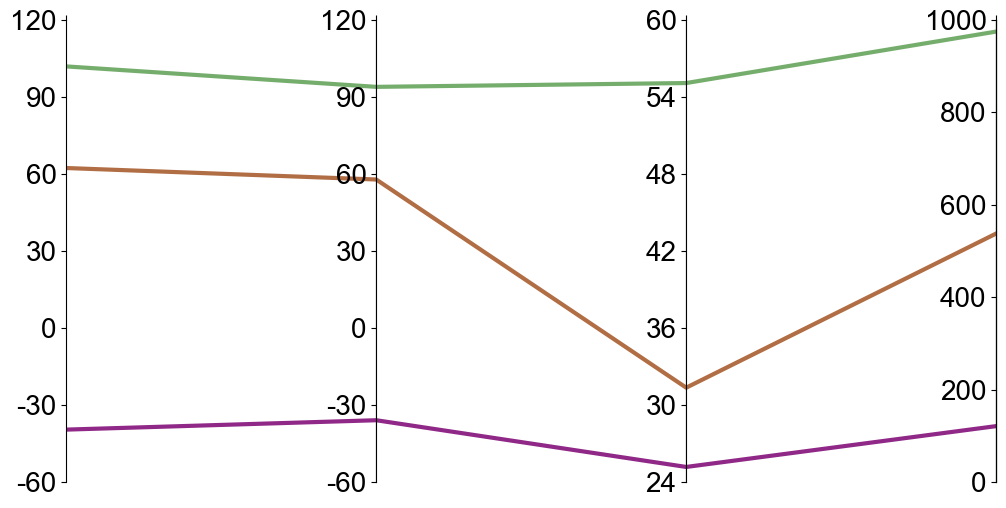

,mean,median,std,max
Exp1,129.200252,119.441670,64.642732,1097.26310
Exp2,27.280510,21.998485,17.844783,621.28770
Exp3,66.869134,61.017563,35.356942,833.32460
Exp1-Exp2,101.919741,93.952012,55.087262,974.96246
Exp1-Exp3,62.331118,57.855314,31.350177,537.84700
Exp2-Exp3,-39.588623,-35.935190,25.172658,120.97016


In [15]:
df = pd.read_csv(f'{data_path}csv/Global_cases_sb.csv')
df1 = df.copy()
stats_df = read_data(df1,'Sbedrock_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

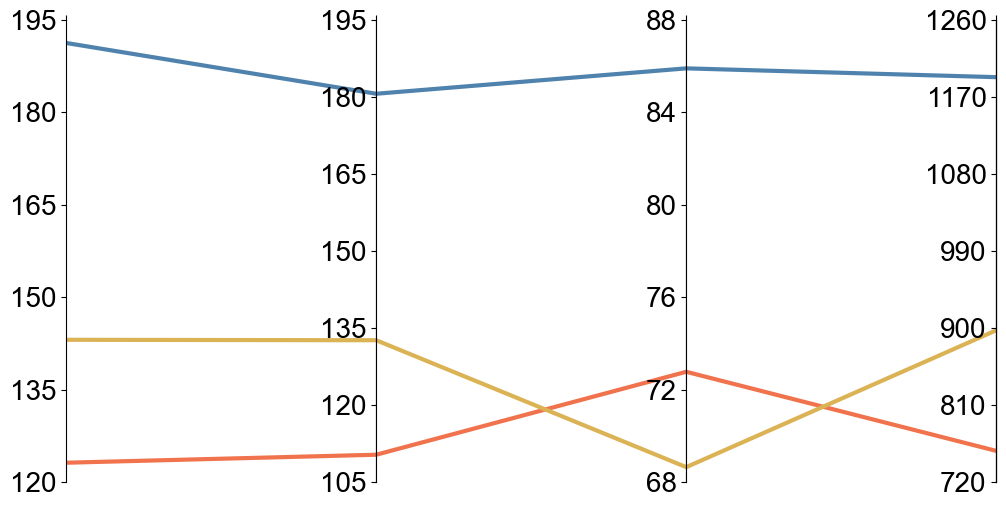

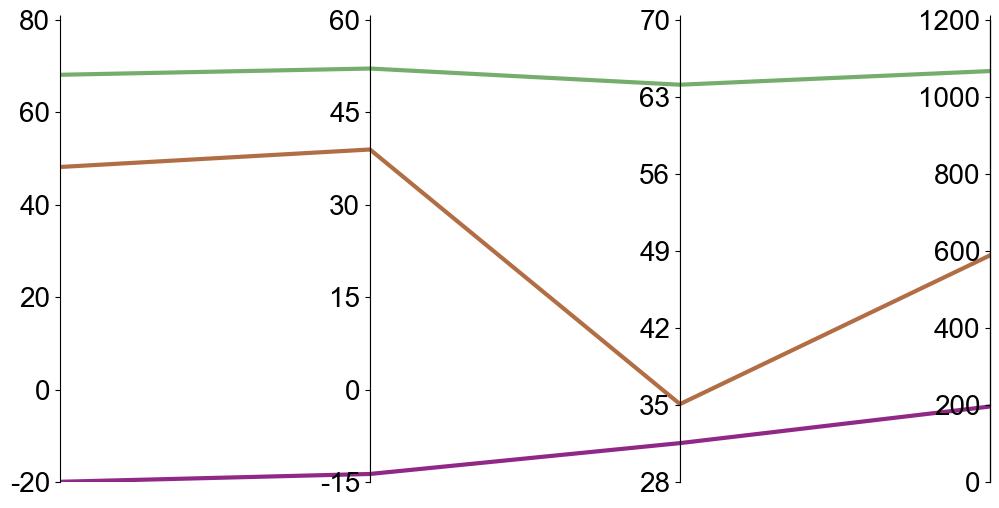

,mean,median,std,max
Exp1,191.270235,180.633570,85.906754,1193.17960
Exp2,123.128933,110.312760,72.770762,756.37067
Exp3,143.085157,132.614620,68.642879,897.29926
Exp1-Exp2,68.141302,52.121890,64.117045,1067.32920
Exp1-Exp3,48.185078,38.978370,35.082317,588.59670
Exp2-Exp3,-19.956225,-13.695309,31.534984,196.05330


In [16]:
df = pd.read_csv(f'{data_path}csv/Global_cases_ss.csv')
df1 = df.copy()
stats_df = read_data(df1,'Ssoil_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

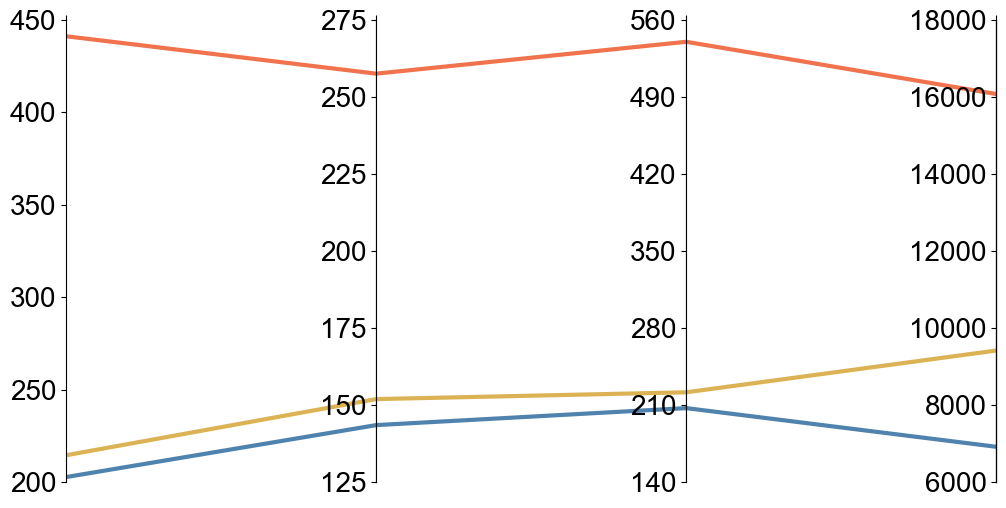

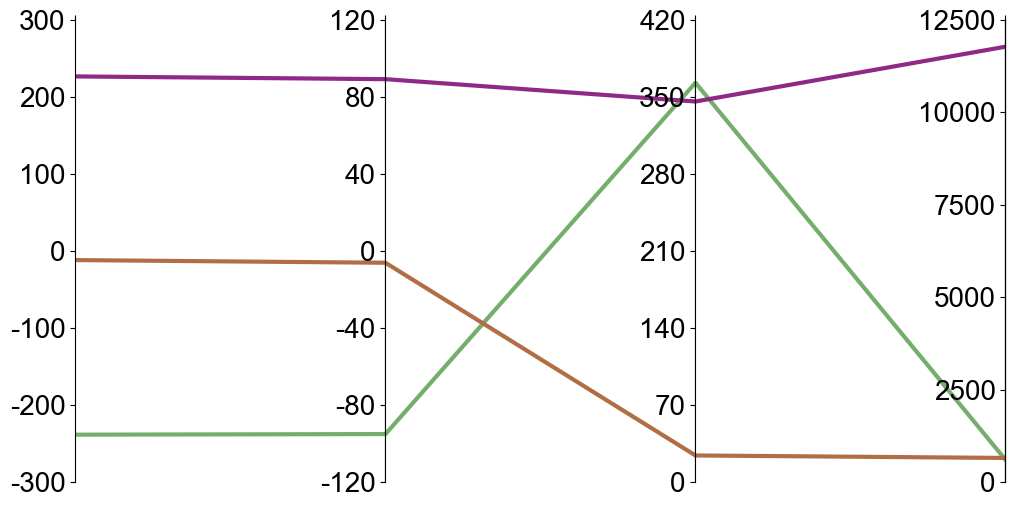

,mean,median,std,max
Exp1,202.676581,143.470720,207.168035,6914.90970
Exp2,441.204173,257.578200,540.191077,16077.47900
Exp3,214.480429,151.920270,221.544576,9414.65500
Exp1-Exp2,-238.527591,-95.102800,362.982343,601.50274
Exp1-Exp3,-11.803847,-6.106080,24.133227,650.72387
Exp2-Exp3,226.723744,89.264452,345.911268,11777.36750


In [17]:
df = pd.read_csv(f'{data_path}csv/Global_cases_runoff_et.csv')
df1 = df.copy()
stats_df = read_data(df1,'rnof_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df

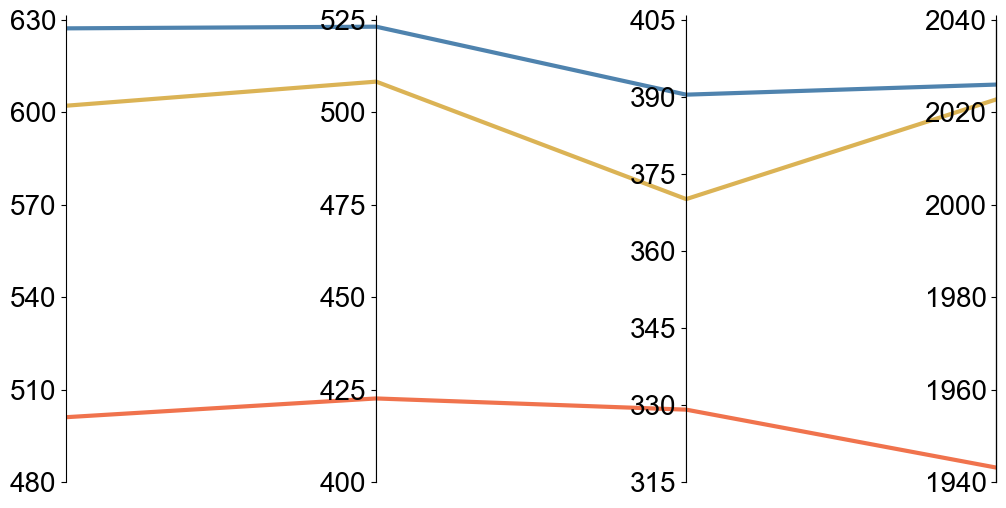

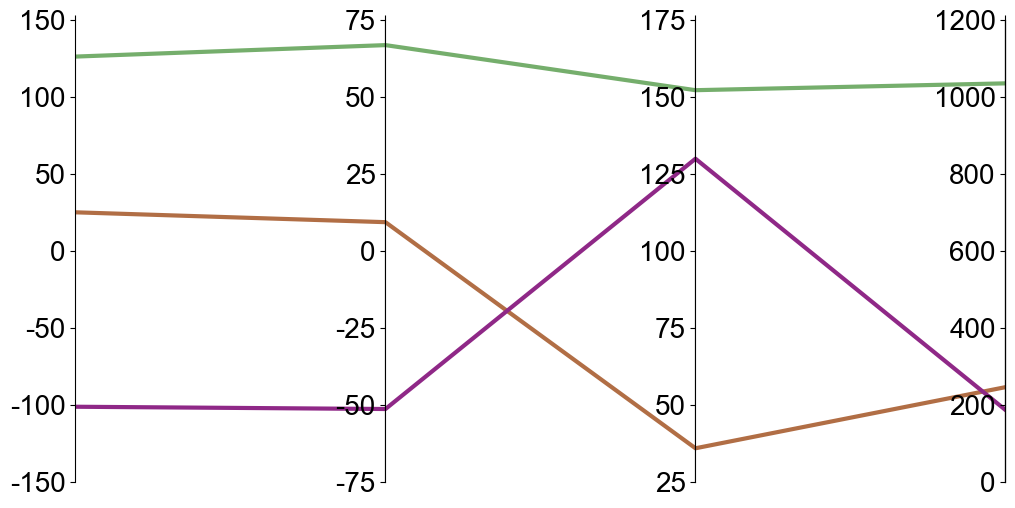

,mean,median,std,max
Exp1,627.289880,523.18640,390.455310,2026.02270
Exp2,501.041003,422.60580,329.094182,1943.11960
Exp3,602.170573,508.32504,370.112423,2022.80870
Exp1-Exp2,126.248877,66.84578,152.210574,1035.44206
Exp1-Exp3,25.119308,9.36084,35.951024,246.35100
Exp2-Exp3,-101.129569,-51.30182,129.958975,187.08346


In [18]:
stats_df = read_data(df1,'fevpa_mean')
draw_exp(stats_df)
draw_exp(stats_df,True)
stats_df